In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
import cv2

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from glob import glob
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample', 'sample_labels.csv']


In [86]:
# ../input/
PATH = os.path.abspath(os.path.join('..', 'input'))

# ../input/sample/images/
SOURCE_IMAGES = os.path.join(PATH, "sample", "images")

# ../input/sample/images/*.png
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

# Load labels
labels = pd.read_csv('../input/sample_labels.csv')

###Since there are some questions about the accuracy of the data labeling as discussed elsewhere, https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/,  I want to make this data analysis meaningful by only detecting informative information by distinguishing between No Finding and Have Finding. This is already very valuable for helping doctors confirm the thought when facing some vague images.

In [87]:
labels.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


##At the first step, I would like to see if there is gender difference for this kind of problems.

In [92]:
M_total = labels[labels['Patient Gender']=='M']['Patient Gender'].value_counts()[0]
F_total = labels[labels['Patient Gender']=='F']['Patient Gender'].value_counts()[0]
labels['NumLabel']=labels['Finding Labels'].apply(lambda x: 'No Finding' if 'No Finding' in x else 'Found!')
M_bad = labels[(labels['NumLabel']=='Found!') & (labels['Patient Gender']=='M')]['Patient Gender'].value_counts()[0]
F_bad = labels[(labels['NumLabel']=='Found!') & (labels['Patient Gender']=='F')]['Patient Gender'].value_counts()[0]

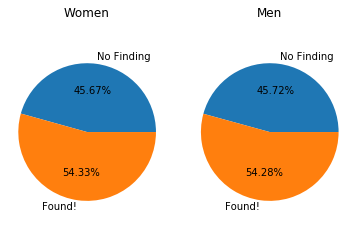

In [81]:
fig, axes = plt.subplots(nrows = 1, ncols =2)

plt.subplot(axes[0])
labels = [u'No Finding',u'Found!']
sizes = [F_bad,F_total-F_bad]
plt.pie( sizes,labels=labels,autopct = '%3.2f%%',labeldistance = 1.1)
plt.axis('equal')
#plt.legend()
plt.title('Women')

plt.subplot(axes[1])
labels = [u'No Finding',u'Found!']
sizes = [M_bad,M_total-M_bad]
plt.pie( sizes,labels=labels,autopct = '%3.2f%%',labeldistance = 1.1)
plt.axis('equal')
#plt.legend()
plt.title('Men')

plt.show()  
fig.savefig('Gender_distribution.png', dpi=300)

##From the plot above, the fraction of having problems in the X-ray images between women and men are basically the same. That means there is no gender bias for this type of diseases. 

Next, I want to see if there is age preference for this.

In [88]:
labels['Age Type']=labels['Patient Age'].apply(lambda x: x[-1:])
labels['Age Type'].unique()  # => Y, M and D

array(['Y', 'M', 'D'], dtype=object)

In [89]:
labels['Age']=labels['Patient Age'].apply(lambda x: x[:-1]).astype(int)

In [90]:
labels.loc[labels['Age Type']=='M',['Age']] = labels[labels['Age Type']=='M']['Age'].apply(lambda x: x/12).astype(int)
labels.loc[labels['Age Type']=='D',['Age']] = labels[labels['Age Type']=='D']['Age'].apply(lambda x: x/365).astype(int)

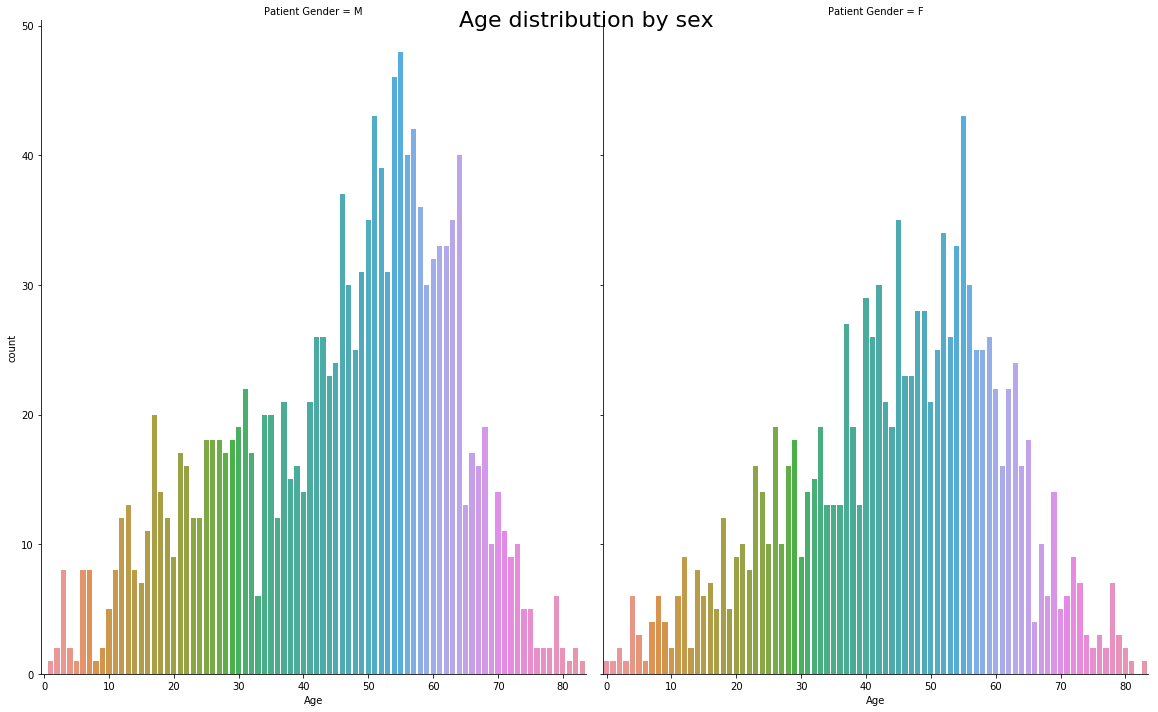

In [94]:
g = sns.factorplot(x="Age", col="Patient Gender",data=labels[labels['NumLabel']=='Found!'], kind="count",size=10, aspect=0.8);
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);
g.fig.suptitle('Age distribution by sex',fontsize=22);

##We can see that there is a peak between 45-60 for both men and women that they may encouter some problems. This age range should catch people's attention!

In [14]:
# load in all of the images
labels['Path'] = labels['Image Index'].apply(lambda x: os.path.join(SOURCE_IMAGES,x))
labels['image'] = labels['Path'].map(imread)

In [15]:
# see the image size distribution
labels['image'].map(lambda x: x.shape).value_counts()

(1024, 1024)       5583
(1024, 1024, 4)      23
Name: image, dtype: int64

##Only a few images have different dimensions from others. This give us some sense how the images should be resized and removed those that have different dimensions.

##Here  I randomly plotted some images that have problems and those having no findings. We can rarely distinguish them. This also raises the significance of building some models to learn and predict.

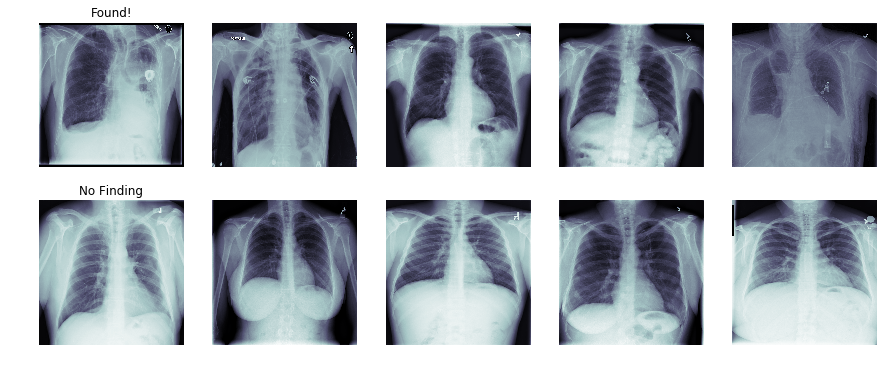

In [16]:
n_samples = 5
fig, m_axs = plt.subplots(2, n_samples, figsize = (3*n_samples, 3*2))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         labels.sort_values(['NumLabel']).groupby('NumLabel')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'],cmap = 'bone')
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [17]:
labels['NumLabel']=labels['Finding Labels'].apply(lambda x: 0 if 'No Finding' in x else 1)

In [18]:
def get_data():
    imgs_x = []
    label_y = []
    for index, row in labels.iterrows():
        if row['image'].shape == (1024,1024):
            imgs_x.append(cv2.resize(row['image'], (150,150), interpolation=cv2.INTER_CUBIC))
            label_y.append(row['NumLabel'])
    return imgs_x, label_y    

In [19]:
X, Y = get_data()
X = np.array(X)/255
X= np.reshape(X, X.shape + (1,))
Y = np.array(Y)

In [20]:
X.shape

(5583, 150, 150, 1)

In [21]:
from sklearn.model_selection import train_test_split    
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2018)
print('Train Shape', X_train.shape, 'test shape', X_test.shape)

Train Shape (3908, 150, 150, 1) test shape (1675, 150, 150, 1)


In [23]:
# from keras.models import Sequential
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, RMSprop


model = Sequential()
# conv1
model.add(Conv2D(16, kernel_size=(3,3),activation='relu', padding='same',input_shape=(150,150,1)))
model.add(Conv2D(16, kernel_size=(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# conv2
model.add(Conv2D(32, kernel_size=(3,3),activation='relu', padding='same',input_shape=(150,150,1)))
model.add(Conv2D(32, kernel_size=(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#conv3
model.add(Conv2D(64, kernel_size=(3,3),activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#conv4
model.add(Conv2D(96, kernel_size=(3,3),dilation_rate = (2,2), activation='relu', padding='same'))
model.add(Conv2D(96, kernel_size=(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#conv5
model.add(Conv2D(128, kernel_size=(3,3),dilation_rate = (2,2), activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=(3,3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# fc
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.00005), metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs = 15, batch_size = 64, verbose=1, validation_data=(X_test, y_test))

Train on 3908 samples, validate on 1675 samples
Epoch 1/20
3908/3908 [==============================] - 394s 101ms/step - loss: 0.8185 - acc: 0.5468 - val_loss: 0.7576 - val_acc: 0.5528
Epoch 2/20
3908/3908 [==============================] - 392s 100ms/step - loss: 0.6534 - acc: 0.6466 - val_loss: 0.7196 - val_acc: 0.5875
Epoch 3/20
3908/3908 [==============================] - 386s 99ms/step - loss: 0.5732 - acc: 0.7045 - val_loss: 0.7226 - val_acc: 0.5833
Epoch 4/20
3908/3908 [==============================] - 383s 98ms/step - loss: 0.5195 - acc: 0.7380 - val_loss: 0.7013 - val_acc: 0.5916
Epoch 5/20
3908/3908 [==============================] - 395s 101ms/step - loss: 0.4544 - acc: 0.7892 - val_loss: 0.6962 - val_acc: 0.6084
Epoch 6/20
3908/3908 [==============================] - 383s 98ms/step - loss: 0.3817 - acc: 0.8447 - val_loss: 0.7303 - val_acc: 0.6155
Epoch 7/20
3908/3908 [==============================] - 391s 100ms/step - loss: 0.3440 - acc: 0.8710 - val_loss: 0.7154 - val_a

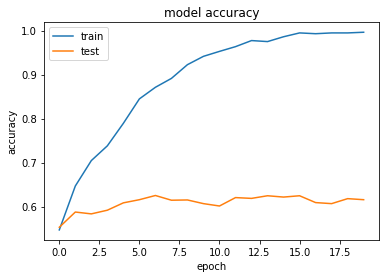

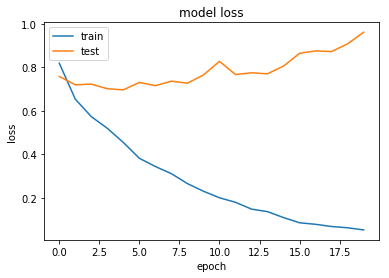

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig.savefig('model_accuracy.png', dpi=300)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig.savefig('model_loss.png', dpi=300)